In [3]:
# prompt: i want to mount my google drive then i want to get the data from the zip OVER HERE https://drive.google.com/drive/home it name is SMAI.zio i want to unzip it to get the data

from google.colab import drive
drive.mount('/content/drive')

# Download the data.
!unzip /content/drive/MyDrive/SMAI.zip -d /content/SMAI



Streaming output truncated to the last 5000 lines.
  inflating: /content/SMAI/content/faces_dataset/train/image_5499.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_55.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_550.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5500.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5501.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5502.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5503.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5504.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5505.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5506.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5507.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5508.jpg  
  inflating: /content/SMAI/content/faces_dataset/train/image_5509.jpg  
  inflating: /co

In [4]:
import numpy as np
import pandas as pd
from glob import glob
from os.path import join
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torch.optim as optim

class AgeDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, annot_path, train=True):
        super(AgeDataset, self).__init__()

        self.annot_path = annot_path
        self.data_path = data_path
        self.train = train

        self.ann = pd.read_csv(annot_path)
        self.files = self.ann['file_id']
        if train:
            self.ages = self.ann['age']
        self.transform = self._transform(224)

    @staticmethod
    def _convert_image_to_rgb(image):
        return image.convert("RGB")

    def _transform(self, n_px):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        return Compose([
            Resize(n_px),
            self._convert_image_to_rgb,
            ToTensor(),
            Normalize(mean, std),
        ])

    def read_img(self, file_name):
        im_path = join(self.data_path,file_name)
        img = Image.open(im_path)
        img = self.transform(img)
        return img

    def __getitem__(self, index):
        file_name = self.files[index]
        img = self.read_img(file_name)
        if self.train:
            age = self.ages[index]
            return img, age
        else:
            return img

    def __len__(self):
        return len(self.files)


train_path = '/content/SMAI/content/faces_dataset/train'
train_ann = '/content/SMAI/content/faces_dataset/train.csv'
train_dataset = AgeDataset(train_path, train_ann, train=True)


test_path = '/content/SMAI/content/faces_dataset/test'
test_ann = '/content/SMAI/content/faces_dataset/submission.csv'
test_dataset = AgeDataset(test_path, test_ann, train=False)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=42)
# Create training and validation samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Create data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=val_sampler)






90


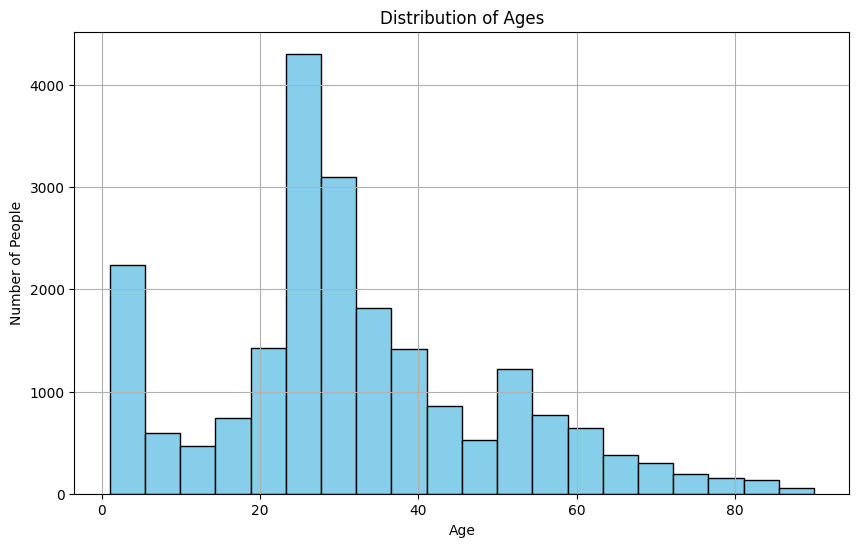

In [5]:
import matplotlib.pyplot as plt

# Extract ages from the training dataset
ages = train_dataset.ages
print(max(ages))
# Plot the distribution of ages
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.grid(True)
plt.show()


In [6]:
print(train_dataset[0][1])
print(train_dataset[0][0].shape)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


35
torch.Size([3, 224, 224])


In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Unfreeze some layers
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:  # Unfreeze last layer and fc layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the last layer for age detection task
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Output 1 value for age prediction

# Define loss function and optimizer
criterion = nn.MSELoss()  # Assuming age is predicted as regression, you might want to use Mean Squared Error loss
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)  # Only optimize parameters of the last layer

# Use a different optimizer and learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Decrease learning rate every 7 epochs

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Assuming age is a single value, so we use squeeze
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), labels.float()).item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


Epoch [1/10], Training Loss: 101.1836
Validation Loss: 13.8818
Epoch [2/10], Training Loss: 42.2152
Validation Loss: 12.9212
Epoch [3/10], Training Loss: 27.6423
Validation Loss: 12.4056
Epoch [4/10], Training Loss: 17.3256
Validation Loss: 17.6745
Epoch [5/10], Training Loss: 14.1240
Validation Loss: 14.6272
Epoch [6/10], Training Loss: 11.9543
Validation Loss: 11.9599
Epoch [7/10], Training Loss: 9.9379
Validation Loss: 11.7462
Epoch [8/10], Training Loss: 6.7672
Validation Loss: 11.3266
Epoch [9/10], Training Loss: 5.7351
Validation Loss: 11.2566
Epoch [10/10], Training Loss: 4.6910
Validation Loss: 11.3351


In [8]:
import pandas as pd
from tqdm import tqdm

# Function to predict ages for the test set
def predict_test(loader, model):
    model.eval()
    predictions = []

    for img in tqdm(loader):
        img = img.to(device)
        pred = model(img)
        predictions.extend(pred.flatten().detach().tolist())

    return predictions

# Generate predictions for the test set
test_predictions = predict_test(test_loader, model)

# Round predictions to nearest integer
rounded_predictions = [round(pred) for pred in test_predictions]

# Load the submission file template
submission_template = pd.read_csv('/content/SMAI/content/faces_dataset/submission.csv')

# Update the age column with predictions
submission_template['age'] = rounded_predictions

# Save the submission file
submission_template.to_csv('submission.csv', index=False)


100%|██████████| 31/31 [00:10<00:00,  2.98it/s]
